In [1]:
import pyspark
from pyspark import SparkContext 
import os
import math
import sys
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.sql.types import Row
from pyspark.sql.types import *
from decimal import Decimal
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pandas import DataFrame
import pandas as pd
import json
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

extraction des données du fichier data.csv et nettoyage du dataframe

In [2]:
df=pd.read_csv('data.csv', sep=',',engine='python')
df = df.iloc[: , 1:]
df=df.drop(['Date'], axis=1)
df=df.rename(columns={"DateTime": 'Date',"ClosePrice":'Close','OpenPrice':'Open'})
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")

In [3]:
df.index=df['Date']
df

,Close,Open,HighPrice,LowPrice,Date
Date,,,,,
2019-04-17,606.8,603.6,607.6,602.4,2019-04-17
2019-04-18,610.0,604.6,610.0,601.4,2019-04-18
2019-04-23,613.0,610.0,615.8,605.4,2019-04-23
2019-04-24,619.0,611.0,619.4,610.8,2019-04-24
2019-04-25,617.8,620.6,622.0,612.0,2019-04-25
...,...,...,...,...,...
2022-04-08,1294.0,1288.5,1295.0,1271.0,2022-04-08
2022-04-11,1252.5,1290.0,1292.5,1247.0,2022-04-11
2022-04-12,1263.0,1240.0,1284.0,1227.5,2022-04-12


In [4]:
print(type(df.index[1]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Affichage des datas Close price en fonction de la date

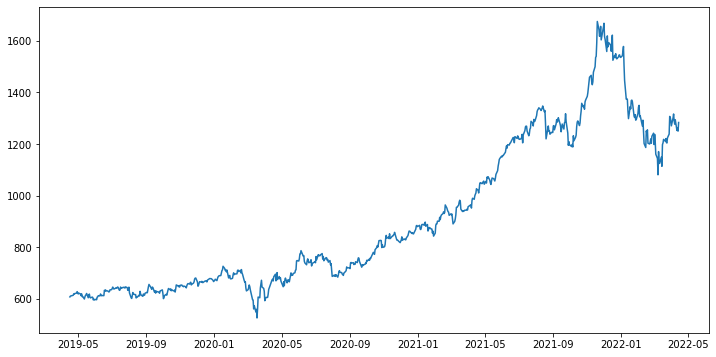

In [5]:
plt.figure(figsize=(12,6))
plt.plot(df["Close"],label='Close Price history')

In [6]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

    

Decoupage en train et fiting des data avec minmax

In [7]:
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset=new_dataset.values

train_data=final_dataset[0:650,:]
valid_data=final_dataset[650:,:]

scaled_data=scaler.fit_transform(train_data)

In [8]:
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

Appel de la methode lstm sur le train set (650 jours) pour predict les 116 jours restant, epochs placé à 1 pour que le code tourne rapidement pour le moment

In [9]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)


Epoch 1/1
 - 28s - loss: 0.0035


In [10]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


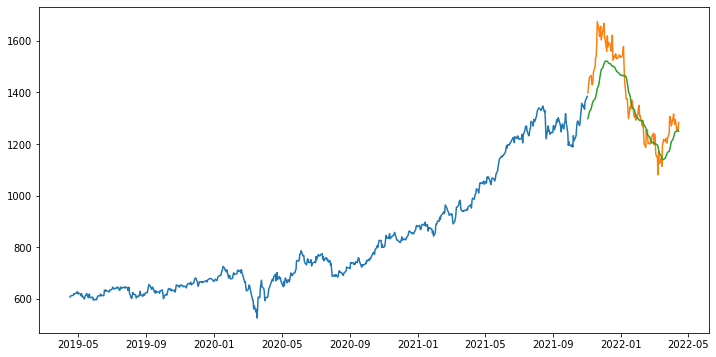

In [11]:
train_data=new_dataset[:650]
valid_data=new_dataset[650:]
valid_data['Predictions']=predicted_closing_price
plt.figure(figsize=(12,6))
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [12]:
df.index[-1]

Timestamp('2022-04-14 00:00:00')

les resultats de l algo sont interressant, mais ce que je cherche à faire cest considéré l ensemble du csv comme training set et prédire les 100 jours suivants la date du 14 avril 2022
à savoir que je ne suis pas obligé de travailler avec des dates mais avec avec des int de 0 à 766 et prédire 100 jours supplémentaire